**Installing dependencies**

In [1]:
!apt-get install -y poppler-utils
!apt-get install -y tesseract-ocr
!pip install pdf2image pytesseract Pillow


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.10).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [2]:
# =========================
# 1️⃣ Install Tensorlake SDK
# =========================
!pip install tensorlake --quiet

# =========================
# 2️⃣ Import necessary libraries
# =========================
from tensorlake.documentai import DocumentAI, StructuredExtractionOptions, ParseStatus
from pydantic import BaseModel
from typing import List
import json
from google.colab import files
import os

# =========================
# 3️⃣ Define Pydantic models
# =========================
class CVEducation(BaseModel):
    degree: str
    institution: str
    year: str

class CVData(BaseModel):
    name: str
    surname: str
    email: str
    phone: str
    education: List[CVEducation]
    skills: List[str]

class DiplomaData(BaseModel):
    degree: str
    institution: str
    student_name: str
    graduation_year: str

class CINData(BaseModel):
    full_name: str
    cin_number: str
    birth_date: str
    address: str
    expiration_date: str

# =========================
# 4️⃣ Upload files
# =========================
uploaded_files = files.upload()
file_paths = list(uploaded_files.keys())

# =========================
# 5️⃣ Initialize Tensorlake
# =========================
TENSORLAKE_API_KEY = "tl_apiKey_THW7hHkdRWhFrR8gzK9G7_Bw81bIpOdSTA-9nmAB12k_tXUXrzZ9"
doc_ai = DocumentAI(api_key=TENSORLAKE_API_KEY)

# =========================
# 6️⃣ Define schema mapping
# =========================
schema_mapping = {
    "cv": CVData,
    "diploma": DiplomaData,
    "cin": CINData
}

# =========================
# =========================
# 7️⃣ Detect document type (with OCR fallback)
# =========================
import pytesseract
from pdf2image import convert_from_path
from PIL import Image

def extract_text_with_ocr(file_path):
    text = ""
    try:
        if file_path.lower().endswith(".pdf"):
            # Convert PDF pages to images
            pages = convert_from_path(file_path, 300)
            for page in pages:
                text += pytesseract.image_to_string(page, lang="eng+fra")
        else:
            # Assume it's an image (jpg, png, etc.)
            img = Image.open(file_path)
            text = pytesseract.image_to_string(img, lang="eng+fra")
    except Exception as e:
        print(f"OCR failed for {file_path}: {e}")
    return text.lower()

def detect_doc_type_local(file_path):
    fname = os.path.basename(file_path).lower()

    # 🎯 CV detection
    if any(k in fname for k in ["cv", "resume"]):
        return "cv"

    # 🎯 Diploma detection
    if any(k in fname for k in ["diploma", "degree", "diplome", "attestation", "certificate", "licence", "master", "bachelor"]):
        return "diploma"

    # 🎯 CIN detection
    if any(k in fname for k in ["cin", "id", "identity", "carte"]):
        return "cin"

    # Fallback: try OCR text extraction
    text = extract_text_with_ocr(file_path)
    if "curriculum" in text or "resume" in text:
        return "cv"
    elif any(k in text for k in ["diploma", "diplome", "degree", "attestation", "certificate"]):
        return "diploma"
    elif any(k in text for k in ["cin", "identity", "carte nationale"]):
        return "cin"

    # Default fallback
    return "cv"


# =========================
# 8️⃣ Extract data
# =========================
all_data = {}

for path in file_paths:
    doc_type = detect_doc_type_local(path)
    print(f"Processing {path} as {doc_type}")

    file_id = doc_ai.upload(path)

    structured_options = StructuredExtractionOptions(
        schema_name=doc_type,
        json_schema=schema_mapping[doc_type]
    )

    result = doc_ai.parse_and_wait(file_id, structured_extraction_options=[structured_options])

    if result.status == ParseStatus.SUCCESSFUL:
        sd = result.structured_data
        if isinstance(sd, list):
            all_data[path] = [item.model_dump() for item in sd]
        else:
            all_data[path] = sd.model_dump()
    else:
        all_data[path] = {"error": "Failed to extract data"}

# =========================
# 9️⃣ Save all extracted data to JSON
# =========================
output_filename = "extracted_data.json"
output_path = os.path.join("/content/", output_filename)
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(all_data, f, indent=4, ensure_ascii=False)

print(f"✅ Extraction complete. JSON file saved as {output_path}")

# # =========================
# # 10️⃣ Download the JSON file
# # =========================
# files.download(output_path) # Removed download to keep file in content directory

Saving Modele_diplome_traditionnel_et_digne_Paysage_15d6dda7e3.png to Modele_diplome_traditionnel_et_digne_Paysage_15d6dda7e3 (2).png
Processing Modele_diplome_traditionnel_et_digne_Paysage_15d6dda7e3 (2).png as diploma


Output()

Parse ID: parse_FJF9dfJCz8RcN87GLJBGb

✅ Extraction complete. JSON file saved as /content/extracted_data.json


In [3]:
import pandas as pd, json, sqlite3
from google.colab import files
import os

# 1️⃣ Charger ton fichier JSON extrait
output_filename = "extracted_data.json"
output_path = os.path.join("/content/", output_filename)

if not os.path.exists(output_path):
    print(f"❌ Erreur: Le fichier '{output_filename}' n'a pas été trouvé à l'emplacement attendu.")
    print("Veuillez exécuter la cellule précédente pour générer le fichier JSON.")
else:
    with open(output_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    # 2️⃣ Transformer en liste de lignes
    rows = []
    for file, content in data.items():
        if isinstance(content, dict):
            # Convert the dictionary to a JSON string
            content['data'] = json.dumps(content['data']) if 'data' in content and isinstance(content['data'], dict) else content.get('data')
            rows.append({"file": file, **content})
        elif isinstance(content, list):
            for item in content:
                # Convert the dictionary to a JSON string for each item in the list
                item['data'] = json.dumps(item['data']) if 'data' in item and isinstance(item['data'], dict) else item.get('data')
                rows.append({"file": file, **item})

    df = pd.DataFrame(rows)

    print("✅ Aperçu des données")
    display(df.head())

    # 3️⃣ Créer/ouvrir une base SQLite
    conn = sqlite3.connect('rh.db')
    # convertir toutes les colonnes qui ne sont pas scalaires (listes/dicts) en texte JSON
    import json

    for col in df.columns:
      df[col] = df[col].apply(lambda x: json.dumps(x, ensure_ascii=False) if isinstance(x, (list, dict)) else x)


    # 4️⃣ Insérer le DataFrame dans la table 'documents_rh'
    df.to_sql('documents_rh', conn, if_exists='replace', index=False)

    print("✅ Données insérées dans la base SQLite 'rh.db'")

    # 5️⃣ Vérifier avec une requête SELECT
    df_check = pd.read_sql('SELECT * FROM documents_rh', conn)
    print("📊 Données stockées dans la base :")
    display(df_check.head())

    # 6️⃣ Fermer la connexion
    conn.close()

    # 7️⃣ Télécharger le fichier de base de données
    files.download('rh.db')
    print("⬇️ Fichier 'rh.db' prêt à être téléchargé")

✅ Aperçu des données


,file,data,page_numbers,schema_name
0,Modele_diplome_traditionnel_et_digne_Paysage_1...,"{""degree"": ""DIPL\u00d4ME D'\u00c9TUDES SUP\u00...",[1],diploma


✅ Données insérées dans la base SQLite 'rh.db'
📊 Données stockées dans la base :


,file,data,page_numbers,schema_name
0,Modele_diplome_traditionnel_et_digne_Paysage_1...,"{""degree"": ""DIPL\u00d4ME D'\u00c9TUDES SUP\u00...",[1],diploma


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

⬇️ Fichier 'rh.db' prêt à être téléchargé


**Affichage des Résultats**

In [4]:
# =========================
# 11️⃣ Afficher les résultats de façon lisible
# =========================
from IPython.display import display, JSON, HTML
import pandas as pd

print("📊 RÉSULTATS DE L'EXTRACTION")
print("=" * 50)

for file_path, data in all_data.items():
    print(f"\n📄 Fichier: {file_path}")
    print("-" * 30)

    if isinstance(data, dict) and "error" in data:
        print(f"❌ Erreur: {data['error']}")
    else:
        # Afficher en format JSON propre
        display(JSON(data))

        # Option: convertir en DataFrame pour une meilleure visualisation
        if isinstance(data, list) and len(data) > 0:
            df = pd.DataFrame(data)
            display(df)

📊 RÉSULTATS DE L'EXTRACTION

📄 Fichier: Modele_diplome_traditionnel_et_digne_Paysage_15d6dda7e3 (2).png
------------------------------


<IPython.core.display.JSON object>

,data,page_numbers,schema_name
0,"{'degree': 'DIPLÔME D'ÉTUDES SUPÉRIEURES', 'gr...",[1],diploma


**Génération du rapport d'extraction**

In [7]:
# =========================
# 11️⃣ Afficher les résultats de façon lisible
# =========================
from IPython.display import display, JSON, HTML
import pandas as pd

print("📊 RÉSULTATS DE L'EXTRACTION")
print("=" * 50)

for file_path, data in all_data.items():
    print(f"\n📄 Fichier: {file_path}")
    print("-" * 30)

    if isinstance(data, dict) and "error" in data:
        print(f"❌ Erreur: {data['error']}")
    else:
        # Afficher en format JSON propre
        display(JSON(data))

        # Option: convertir en DataFrame pour une meilleure visualisation
        if isinstance(data, list) and len(data) > 0:
            df = pd.DataFrame(data)
            display(df)

📊 RÉSULTATS DE L'EXTRACTION

📄 Fichier: Modele_diplome_traditionnel_et_digne_Paysage_15d6dda7e3 (2).png
------------------------------


<IPython.core.display.JSON object>

,data,page_numbers,schema_name
0,"{'degree': 'DIPLÔME D'ÉTUDES SUPÉRIEURES', 'gr...",[1],diploma



📄 Fichier: CIN_maroc-1024x670 (2).jpg
------------------------------


<IPython.core.display.JSON object>

,data,page_numbers,schema_name
0,"{'address': 'OUARZAZATE', 'birth_date': '05/12...",[1],cin


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [10]:
import pandas as pd, json, sqlite3
from google.colab import files
import os

# 1️⃣ Charger ton fichier JSON extrait
output_filename = "extracted_data.json"
output_path = os.path.join("/content/", output_filename)

if not os.path.exists(output_path):
    print(f"❌ Erreur: Le fichier '{output_filename}' n'a pas été trouvé à l'emplacement attendu.")
    print("Veuillez exécuter la cellule précédente pour générer le fichier JSON.")
else:
    with open(output_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    # 2️⃣ Transformer en liste de lignes
    rows = []
    for file, content in data.items():
        if isinstance(content, dict):
            # Convert the dictionary to a JSON string
            content['data'] = json.dumps(content['data']) if 'data' in content and isinstance(content['data'], dict) else content.get('data')
            rows.append({"file": file, **content})
        elif isinstance(content, list):
            for item in content:
                # Convert the dictionary to a JSON string for each item in the list
                item['data'] = json.dumps(item['data']) if 'data' in item and isinstance(item['data'], dict) else item.get('data')
                rows.append({"file": file, **item})

    df = pd.DataFrame(rows)

    print("✅ Aperçu des données")
    display(df.head())

    # 3️⃣ Créer/ouvrir une base SQLite
    conn = sqlite3.connect('rh.db')
    # convertir toutes les colonnes qui ne sont pas scalaires (listes/dicts) en texte JSON
    import json

    for col in df.columns:
      df[col] = df[col].apply(lambda x: json.dumps(x, ensure_ascii=False) if isinstance(x, (list, dict)) else x)


    # 4️⃣ Insérer le DataFrame dans la table 'documents_rh'
    df.to_sql('documents_rh', conn, if_exists='replace', index=False)

    print("✅ Données insérées dans la base SQLite 'rh.db'")

    # 5️⃣ Vérifier avec une requête SELECT
    df_check = pd.read_sql('SELECT * FROM documents_rh', conn)
    print("📊 Données stockées dans la base :")
    display(df_check.head())

    # 6️⃣ Fermer la connexion
    conn.close()

    # 7️⃣ Télécharger le fichier de base de données
    files.download('rh.db')
    print("⬇️ Fichier 'rh.db' prêt à être téléchargé")

✅ Aperçu des données


,file,data,page_numbers,schema_name
0,Modele_diplome_traditionnel_et_digne_Paysage_1...,"{""degree"": ""DIPL\u00d4ME D'\u00c9TUDES SUP\u00...",[1],diploma


✅ Données insérées dans la base SQLite 'rh.db'
📊 Données stockées dans la base :


,file,data,page_numbers,schema_name
0,Modele_diplome_traditionnel_et_digne_Paysage_1...,"{""degree"": ""DIPL\u00d4ME D'\u00c9TUDES SUP\u00...",[1],diploma


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

⬇️ Fichier 'rh.db' prêt à être téléchargé


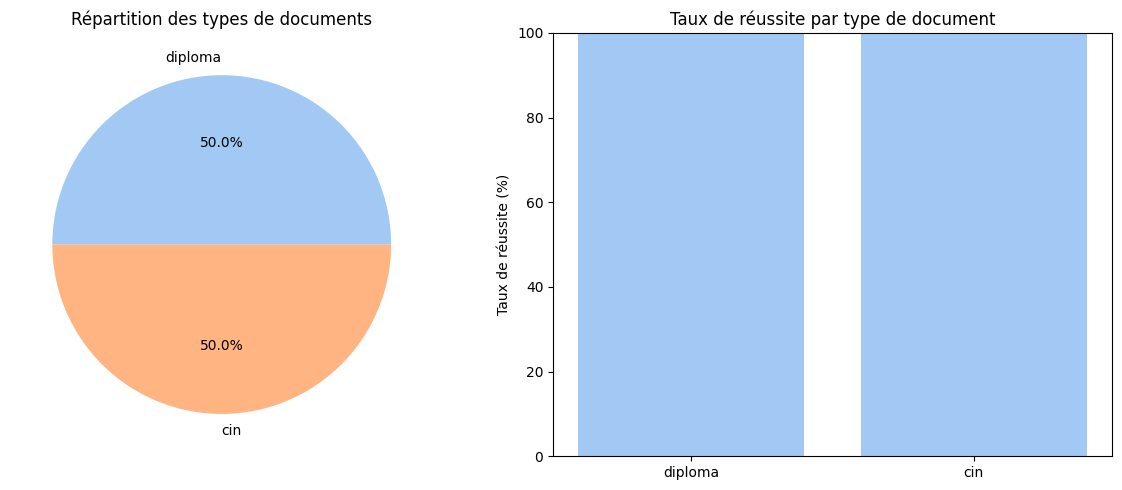

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 640x480 with 0 Axes>

In [8]:
# =========================
# 13️⃣ Visualisations des données extraites
# =========================
import matplotlib.pyplot as plt
import seaborn as sns

# Configurer le style
plt.style.use('default')
sns.set_palette("pastel")

# Compter les types de documents
doc_types = []
for file_path in all_data.keys():
    doc_types.append(detect_doc_type_local(file_path))

# Créer un graphique
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Graphique 1: Répartition des types de documents
doc_counts = pd.Series(doc_types).value_counts()
ax1.pie(doc_counts.values, labels=doc_counts.index, autopct='%1.1f%%')
ax1.set_title('Répartition des types de documents')

# Graphique 2: Taux de réussite par type
success_rates = {}
for doc_type in doc_counts.index:
    count = doc_counts[doc_type]
    successes = sum(1 for file_path, data in all_data.items()
                   if detect_doc_type_local(file_path) == doc_type and not isinstance(data, dict))
    success_rates[doc_type] = (successes / count) * 100

ax2.bar(success_rates.keys(), success_rates.values())
ax2.set_title('Taux de réussite par type de document')
ax2.set_ylabel('Taux de réussite (%)')
ax2.set_ylim(0, 100)

plt.tight_layout()
plt.show()

# Sauvegarder le graphique
plt.savefig("extraction_stats.png", dpi=300, bbox_inches='tight')
files.download("extraction_stats.png")

In [9]:
# 1️⃣ Installer Gradio
!pip install gradio --quiet

# 2️⃣ Importer les libs nécessaires (Tensorlake + OCR)
from tensorlake.documentai import DocumentAI, StructuredExtractionOptions, ParseStatus
from pydantic import BaseModel
from typing import List
import os, json
import pytesseract
from pdf2image import convert_from_path
from PIL import Image
import gradio as gr

# 3️⃣ Définir les schémas de données
class CVEducation(BaseModel):
    degree: str
    institution: str
    year: str

class CVData(BaseModel):
    name: str
    surname: str
    email: str
    phone: str
    education: List[CVEducation]
    skills: List[str]

class DiplomaData(BaseModel):
    degree: str
    institution: str
    student_name: str
    graduation_year: str

class CINData(BaseModel):
    full_name: str
    cin_number: str
    birth_date: str
    address: str
    expiration_date: str

schema_mapping = {
    "cv": CVData,
    "diploma": DiplomaData,
    "cin": CINData
}

# 4️⃣ Initialiser l'API Tensorlake
TENSORLAKE_API_KEY = "tl_apiKey_jFbLCBMmFFHBLgbngDt7f_UNKA4K0f52q2e7pB1u0FSXTFsCqrCt"  # <-- mets ta clé ici
doc_ai = DocumentAI(api_key=TENSORLAKE_API_KEY)

# 5️⃣ Fonctions utilitaires
def extract_text_with_ocr(file_path):
    text = ""
    try:
        if file_path.lower().endswith(".pdf"):
            pages = convert_from_path(file_path, 300)
            for page in pages:
                text += pytesseract.image_to_string(page, lang="eng+fra")
        else:
            img = Image.open(file_path)
            text = pytesseract.image_to_string(img, lang="eng+fra")
    except Exception as e:
        print(f"OCR failed for {file_path}: {e}")
    return text.lower()

def detect_doc_type_local(file_path):
    fname = os.path.basename(file_path).lower()

    if any(k in fname for k in ["cv", "resume"]):
        return "cv"
    if any(k in fname for k in ["diploma", "degree", "diplome", "attestation", "certificate", "licence", "master", "bachelor"]):
        return "diploma"
    if any(k in fname for k in ["cin", "id", "identity", "carte"]):
        return "cin"

    text = extract_text_with_ocr(file_path)
    if "curriculum" in text or "resume" in text:
        return "cv"
    elif any(k in text for k in ["diploma", "diplome", "degree", "attestation", "certificate"]):
        return "diploma"
    elif any(k in text for k in ["cin", "identity", "carte nationale"]):
        return "cin"
    return "cv"

# 6️⃣ Fonction d'extraction pour Gradio
def extract_data(file_obj):
    path = file_obj.name
    doc_type = detect_doc_type_local(path)
    file_id = doc_ai.upload(path)

    structured_options = StructuredExtractionOptions(
        schema_name=doc_type,
        json_schema=schema_mapping[doc_type]
    )

    result = doc_ai.parse_and_wait(file_id, structured_extraction_options=[structured_options])

    if result.status == ParseStatus.SUCCESSFUL:
        sd = result.structured_data
        if isinstance(sd, list):
            return [item.model_dump() for item in sd]
        else:
            return sd.model_dump()
    else:
        return {"error": "Failed to extract data"}

# 7️⃣ Interface Gradio
iface = gr.Interface(
    fn=extract_data,
    inputs=gr.File(label="Téléverse un CV / diplôme / CIN"),
    outputs="json",
    title="Portail RH - Extraction automatique",
    description="Upload un document RH pour extraire automatiquement ses informations clés."
)

iface.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://2bfbb998a439f36c12.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [11]:
import pandas as pd, json, sqlite3
from google.colab import files
import os

# 1️⃣ Charger ton fichier JSON extrait
output_filename = "extracted_data.json"
output_path = os.path.join("/content/", output_filename)

if not os.path.exists(output_path):
    print(f"❌ Erreur: Le fichier '{output_filename}' n'a pas été trouvé à l'emplacement attendu.")
    print("Veuillez exécuter la cellule précédente pour générer le fichier JSON.")
else:
    with open(output_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    # 2️⃣ Transformer en liste de lignes
    rows = []
    for file, content in data.items():
        if isinstance(content, dict):
            # Convert the dictionary to a JSON string
            content['data'] = json.dumps(content['data']) if 'data' in content and isinstance(content['data'], dict) else content.get('data')
            rows.append({"file": file, **content})
        elif isinstance(content, list):
            for item in content:
                # Convert the dictionary to a JSON string for each item in the list
                item['data'] = json.dumps(item['data']) if 'data' in item and isinstance(item['data'], dict) else item.get('data')
                rows.append({"file": file, **item})

    df = pd.DataFrame(rows)

    print("✅ Aperçu des données")
    display(df.head())

    # 3️⃣ Créer/ouvrir une base SQLite
    conn = sqlite3.connect('rh.db')
    # convertir toutes les colonnes qui ne sont pas scalaires (listes/dicts) en texte JSON
    import json

    for col in df.columns:
      df[col] = df[col].apply(lambda x: json.dumps(x, ensure_ascii=False) if isinstance(x, (list, dict)) else x)


    # 4️⃣ Insérer le DataFrame dans la table 'documents_rh'
    df.to_sql('documents_rh', conn, if_exists='replace', index=False)

    print("✅ Données insérées dans la base SQLite 'rh.db'")

    # 5️⃣ Vérifier avec une requête SELECT
    df_check = pd.read_sql('SELECT * FROM documents_rh', conn)
    print("📊 Données stockées dans la base :")
    display(df_check.head())

    # 6️⃣ Fermer la connexion
    conn.close()

    # 7️⃣ Télécharger le fichier de base de données
    files.download('rh.db')
    print("⬇️ Fichier 'rh.db' prêt à être téléchargé")

✅ Aperçu des données


,file,data,page_numbers,schema_name
0,Modele_diplome_traditionnel_et_digne_Paysage_1...,"{""degree"": ""DIPL\u00d4ME D'\u00c9TUDES SUP\u00...",[1],diploma


✅ Données insérées dans la base SQLite 'rh.db'
📊 Données stockées dans la base :


,file,data,page_numbers,schema_name
0,Modele_diplome_traditionnel_et_digne_Paysage_1...,"{""degree"": ""DIPL\u00d4ME D'\u00c9TUDES SUP\u00...",[1],diploma


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

⬇️ Fichier 'rh.db' prêt à être téléchargé


In [13]:
import gradio as gr
import sqlite3, json, pandas as pd
import os

def extract_and_store(file_obj):
    try:
        path = file_obj.name

        # 1️⃣ Extraire comme avant
        doc_type = detect_doc_type_local(path)
        file_id = doc_ai.upload(path)
        structured_options = StructuredExtractionOptions(
            schema_name=doc_type,
            json_schema=schema_mapping[doc_type]
        )
        result = doc_ai.parse_and_wait(file_id, structured_extraction_options=[structured_options])

        if result.status == ParseStatus.SUCCESSFUL:
            sd = result.structured_data
            if isinstance(sd, list):
                data_out = [item.model_dump() for item in sd]
            else:
                data_out = [sd.model_dump()]

            # 2️⃣ Transformer en DataFrame
            df = pd.DataFrame(data_out)

            # 3️⃣ Convertir listes/dicts en texte JSON pour SQLite
            for col in df.columns:
                df[col] = df[col].apply(
                    lambda x: json.dumps(x, ensure_ascii=False)
                    if isinstance(x, (list, dict)) else x
                )

            # 4️⃣ Ajouter dans la base SQLite
            conn = sqlite3.connect('rh.db')
            df.to_sql('documents_rh', conn, if_exists='append', index=False)
            conn.close()

            # 5️⃣ Sauvegarder un CSV à chaque extraction
            csv_path = "extraction.csv"
            if not os.path.exists(csv_path):
                df.to_csv(csv_path, index=False)
            else:
                df.to_csv(csv_path, mode='a', header=False, index=False)

            # 6️⃣ Retourner le JSON + fichier CSV pour téléchargement
            return data_out, csv_path, "rh.db"

        else:
            return {"error": "Failed to extract data"}, None, None

    except Exception as e:
        import traceback
        return {"error": str(e), "traceback": traceback.format_exc()}, None, None

# --- Interface Gradio avec 3 sorties ---
iface = gr.Interface(
    fn=extract_and_store,
    inputs=gr.File(label="Uploader un document"),
    outputs=[
        gr.JSON(label="Données extraites"),
        gr.File(label="Télécharger le CSV"),
        gr.File(label="Télécharger la base SQLite")
    ],
    title="",
    description="Téléchargez un document RH pour extraire les données et récupérer automatiquement le CSV ou la base SQLite."
)

iface.launch()



It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://2c59e97f072aefc4b6.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
